In [26]:
import pystac_client

from pystac_client import Client
import requests
import planetary_computer as pc

import geopandas as gpd
from bs4 import BeautifulSoup
import pandas as pd
import rasterio
import rioxarray

import matplotlib.pyplot as plt
import xrspatial.multispectral as ms
import seaborn as sns

In [46]:
df1 = pd.read_csv('../Data/wildfires_env_072924.csv', index_col=0)
df1.head()

,COUNTYNAME,Started,Extinguished,Location,Latitude,Longitude,Name,AcresBurned,MajorIncident,PopDensity,...,percent_vegetated_below_0.5,range_-1_0,range_0_0.2,range_0.2_0.5,range_0.5_1,YEAR,MONTH_NUM,UniqueId,CalFireIncident,CanonicalUrl
1257,Santa Barbara,2019-11-25T19:59:12Z,2019-12-14T08:22:00Z,Highway 154 and E Camino Cielo near Painted Ca...,34.502500,-119.785000,Cave Fire (No Longer a CAL FIRE Incident),3126.0,False,10.922251,...,55.865781,0.001907,3.038406,52.826309,44.133377,2019.0,11.0,7555692b-f672-4660-8f15-d0dab068a193,False,/incidents/2019/11/25/cave-fire-no-longer-a-ca...
1222,Placer,2019-11-25T12:39:44Z,NaN,"Foothills and McAnally Drive, northwest of Ros...",38.838992,-121.325842,Foothills Fire,355.0,False,24.667203,...,99.933845,2.549362,92.014694,5.371475,0.064468,2019.0,11.0,77d64e4c-a50f-4f4d-a750-e6a6f0ddadc9,True,/incidents/2019/11/25/foothills-fire/
1475,Yolo,2019-11-25T12:02:02Z,NaN,"County Road 102 and County Road 17, North of W...",38.734634,-121.729691,Cashe Fire,NaN,False,19.970863,...,94.224848,0.510025,76.155853,17.588425,5.745697,2019.0,11.0,9c26f915-1b33-422d-b30a-9eb4da6fd729,False,/incidents/2019/11/25/cashe-fire/
1376,Lake,2019-11-05T06:52:14Z,2019-11-06T18:30:00Z,"Walker Ridge Road and Bartlett Springs Road, n...",39.100408,-122.496548,Eagle Fire,75.0,False,4.504752,...,75.755692,0.000000,5.380249,70.375443,24.244308,2019.0,11.0,600d608d-6279-435d-bc9b-99aacaa5e80f,True,/incidents/2019/11/5/eagle-fire/
1259,Tehama,2019-11-03T14:16:17Z,2019-11-14T18:02:00Z,"Colyer Springs Rd and Raglin Ridge Rd, southwe...",40.036379,-122.637837,Ranch Fire,2534.0,True,2.044474,...,87.695478,0.035858,4.796982,82.867050,12.300110,2019.0,11.0,69d98a94-4980-4dc0-b388-61c37c635f32,True,/incidents/2019/11/3/ranch-fire/


In [14]:
df1.loc[df1.isnull().any(axis=1)]

,COUNTYNAME,Started,Extinguished,Location,Latitude,Longitude,Name,AcresBurned,MajorIncident,PopDensity,...,percent_vegetated_below_0.5,range_-1_0,range_0_0.2,range_0.2_0.5,range_0.5_1,YEAR,MONTH_NUM,UniqueId,CalFireIncident,CanonicalUrl
1222,Placer,2019-11-25T12:39:44Z,NaN,"Foothills and McAnally Drive, northwest of Ros...",38.838992,-121.325842,Foothills Fire,355.0,False,24.667203,...,99.933845,2.549362,92.014694,5.371475,0.064468,2019.0,11.0,77d64e4c-a50f-4f4d-a750-e6a6f0ddadc9,True,/incidents/2019/11/25/foothills-fire/
1475,Yolo,2019-11-25T12:02:02Z,NaN,"County Road 102 and County Road 17, North of W...",38.734634,-121.729691,Cashe Fire,NaN,False,19.970863,...,94.224848,0.510025,76.155853,17.588425,5.745697,2019.0,11.0,9c26f915-1b33-422d-b30a-9eb4da6fd729,False,/incidents/2019/11/25/cashe-fire/
1396,San Diego,2019-10-31T06:39:56Z,NaN,"off of Border road and Canyon Road, Southeast ...",32.564583,-116.834583,Copper Fire,50.0,False,68.368998,...,98.872275,0.144196,47.367477,51.362228,1.126099,2019.0,10.0,e471b23c-f00c-44bc-afc1-6ab02b0af4c3,True,/incidents/2019/10/31/copper-fire/
1254,Los Angeles,2019-10-24T14:51:46Z,NaN,"Tick Canyon Rd and Summit Knoll Rd, Canyon Cou...",34.472778,-118.368056,Tick Fire,4615.0,True,195.772346,...,99.944667,0.035477,78.201675,21.707535,0.055313,2019.0,10.0,020310d3-7834-4f57-a125-eff0eb3f54e5,False,/incidents/2019/10/24/tick-fire/
1380,Marin,2019-10-24T12:15:33Z,NaN,"Highway 1 and Panoramic Hwy, Stinson Beach",37.896231,-122.636471,Muir Fire,67.0,False,29.061694,...,48.517159,39.107513,8.514023,21.029282,31.349182,2019.0,10.0,16b1921b-f753-4a36-85bc-d903555f0af4,True,/incidents/2019/10/24/muir-fire/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,Madera,2013-04-30T12:59:00Z,2013-05-01T07:00:00Z,Between Road 210 and Road 200 near Fine Gold C...,37.116295,-119.635004,Gold Fire,274.0,False,6.527526,...,NaN,NaN,NaN,NaN,NaN,2013.0,4.0,357ffc13-bef9-48eb-810f-c5de851972eb,True,/incidents/2013/4/30/gold-fire/
131,San Bernardino,2013-04-20T17:30:00Z,2013-04-22T09:00:00Z,"west of Delamar Mountain, north of the communi...",34.288877,-116.941311,Fawnskin Fire,30.0,False,9.621094,...,NaN,NaN,NaN,NaN,NaN,2013.0,4.0,58f89ff8-bd3e-4355-b1c0-8fa05c747d3f,False,/incidents/2013/4/20/fawnskin-fire/
39,Inyo,2013-02-24T08:16:00Z,2013-02-28T20:00:00Z,"south of Narrow Gauge Rd & north of Hwy 136, e...",36.602575,-118.016510,River Fire,406.0,True,0.166677,...,NaN,NaN,NaN,NaN,NaN,2013.0,2.0,094719ba-a47b-4abb-9ec5-a506b2b9fd23,True,/incidents/2013/2/24/river-fire/
1111,NaN,1969-12-31T16:00:00Z,2019-01-04T09:22:00Z,"Platform Bridge Rd. and Point Reyes Station, n...",38.071350,-122.767510,Bridge Fire,45.0,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49232e73-c3ba-4dc3-b673-b973a918fa7c,False,/incidents/2018/12/31/bridge-fire/


In [15]:
df1.columns

Index(['COUNTYNAME', 'Started', 'Extinguished', 'Location', 'Latitude',
       'Longitude', 'Name', 'AcresBurned', 'MajorIncident', 'PopDensity',
       'Housing', 'pcp', 'tmax', 'tmin', 'closest_weather_lat',
       'closest_weather_lon', 'season', 'season_year', '24_hour_sp_min',
       '24_hour_sp_max', '24_hour_sp_mean', '24_hour_d2m_min',
       '24_hour_d2m_max', '24_hour_d2m_mean', '24_hour_t2m_min',
       '24_hour_t2m_max', '24_hour_t2m_mean', '24_hour_u10_min',
       '24_hour_u10_max', '24_hour_u10_mean', '24_hour_v10_min',
       '24_hour_v10_max', '24_hour_v10_mean', '24_hour_tp_min',
       '24_hour_tp_max', '24_hour_tp_mean', 'season_sp_min', 'season_sp_max',
       'season_sp_mean', 'season_d2m_min', 'season_d2m_max', 'season_d2m_mean',
       'season_t2m_min', 'season_t2m_max', 'season_t2m_mean', 'season_u10_min',
       'season_u10_max', 'season_u10_mean', 'season_v10_min', 'season_v10_max',
       'season_v10_mean', 'season_tp_min', 'season_tp_max', 'season_tp_mean',

In [31]:
df2 = df1.dropna(subset=['AcresBurned', 'MajorIncident','average_ndvi', 'elevation_mean'])

In [32]:
# Validate null values have been removed for all interested columns
df_val = df2[['AcresBurned', 'MajorIncident', 'slope_max', 'slope_mean', 'slope_min',
       'slope_stdDev', 'elevation_max', 'elevation_mean', 'elevation_min',
       'elevation_stdDev', 'average_ndvi', 'percent_vegetated_below_0.5',
       'range_-1_0', 'range_0_0.2', 'range_0.2_0.5', 'range_0.5_1']]
df_val[df_val.isnull().any(axis=1)]

,AcresBurned,MajorIncident,slope_max,slope_mean,slope_min,slope_stdDev,elevation_max,elevation_mean,elevation_min,elevation_stdDev,average_ndvi,percent_vegetated_below_0.5,range_-1_0,range_0_0.2,range_0.2_0.5,range_0.5_1


In [27]:
# df1 summary acres burned
df1['AcresBurned'].describe()

count      1475.000000
mean       4702.956610
std       28444.059939
min           0.000000
25%          35.000000
50%          97.000000
75%         415.500000
max      410203.000000
Name: AcresBurned, dtype: float64

In [28]:
# df1 summary major incident
df1['MajorIncident'].describe()

count      1478
unique        2
top       False
freq       1129
Name: MajorIncident, dtype: object

In [29]:
# df2 summary acres burned
df2['AcresBurned'].describe()

count      1136.000000
mean       5065.655810
std       30863.966915
min           0.000000
25%          32.000000
50%          86.000000
75%         376.250000
max      410203.000000
Name: AcresBurned, dtype: float64

In [30]:
# df2 summary major incident
df2['MajorIncident'].describe()

count      1136
unique        2
top       False
freq        902
Name: MajorIncident, dtype: object

In [25]:
final_df = df2
df2.head()

,COUNTYNAME,Started,Extinguished,Location,Latitude,Longitude,Name,AcresBurned,MajorIncident,PopDensity,...,percent_vegetated_below_0.5,range_-1_0,range_0_0.2,range_0.2_0.5,range_0.5_1,YEAR,MONTH_NUM,UniqueId,CalFireIncident,CanonicalUrl
1257,Santa Barbara,2019-11-25T19:59:12Z,2019-12-14T08:22:00Z,Highway 154 and E Camino Cielo near Painted Ca...,34.502500,-119.785000,Cave Fire (No Longer a CAL FIRE Incident),3126.0,False,10.922251,...,55.865781,0.001907,3.038406,52.826309,44.133377,2019.0,11.0,7555692b-f672-4660-8f15-d0dab068a193,False,/incidents/2019/11/25/cave-fire-no-longer-a-ca...
1222,Placer,2019-11-25T12:39:44Z,NaN,"Foothills and McAnally Drive, northwest of Ros...",38.838992,-121.325842,Foothills Fire,355.0,False,24.667203,...,99.933845,2.549362,92.014694,5.371475,0.064468,2019.0,11.0,77d64e4c-a50f-4f4d-a750-e6a6f0ddadc9,True,/incidents/2019/11/25/foothills-fire/
1376,Lake,2019-11-05T06:52:14Z,2019-11-06T18:30:00Z,"Walker Ridge Road and Bartlett Springs Road, n...",39.100408,-122.496548,Eagle Fire,75.0,False,4.504752,...,75.755692,0.000000,5.380249,70.375443,24.244308,2019.0,11.0,600d608d-6279-435d-bc9b-99aacaa5e80f,True,/incidents/2019/11/5/eagle-fire/
1259,Tehama,2019-11-03T14:16:17Z,2019-11-14T18:02:00Z,"Colyer Springs Rd and Raglin Ridge Rd, southwe...",40.036379,-122.637837,Ranch Fire,2534.0,True,2.044474,...,87.695478,0.035858,4.796982,82.867050,12.300110,2019.0,11.0,69d98a94-4980-4dc0-b388-61c37c635f32,True,/incidents/2019/11/3/ranch-fire/
1446,Riverside,2019-11-01T13:04:34Z,2019-11-01T08:55:00Z,"off of La Sierra Ave and Tin Mine Road, East ...",33.849906,-117.461363,Sobrante Fire,19.0,False,31.364971,...,98.986009,20.959091,67.675400,10.564041,0.801468,2019.0,11.0,305f30f5-622d-4c55-8813-45ffbc15aed0,True,/incidents/2019/11/1/sobrante-fire/


<Axes: xlabel='AcresBurned', ylabel='AcresBurned'>

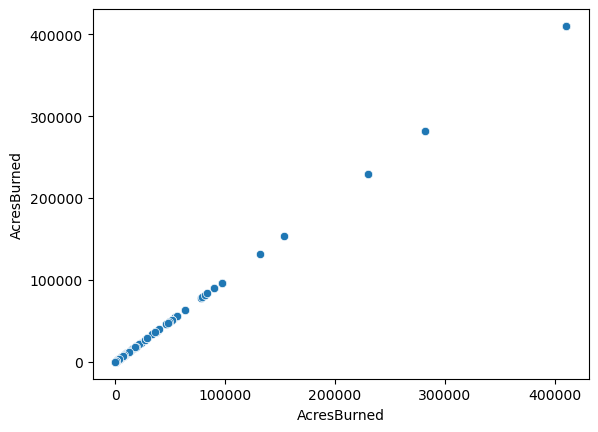

In [39]:
sns.scatterplot(x=final_df.AcresBurned, y=final_df.AcresBurned)

In [40]:
from sklearn.model_selection import train_test_split


In [41]:
train, temp = train_test_split(final_df, test_size=.4, train_size=.6, random_state=1234)
test, val = train_test_split(temp, test_size=.5, train_size=.5, random_state=1234)

Text(0.5, 1.0, 'train')

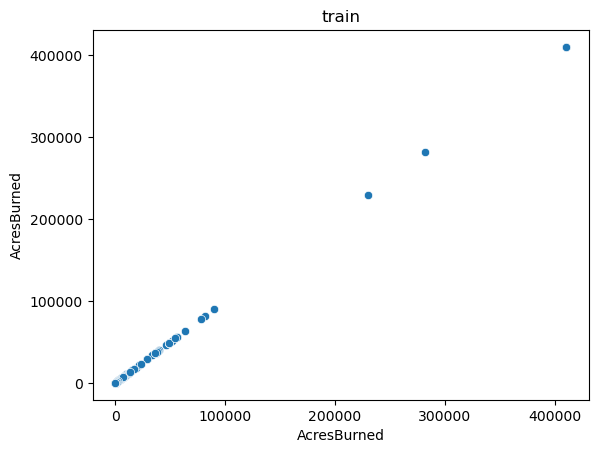

In [42]:
sns.scatterplot(x=train.AcresBurned, y=train.AcresBurned)
plt.title('train')

Text(0.5, 1.0, 'test')

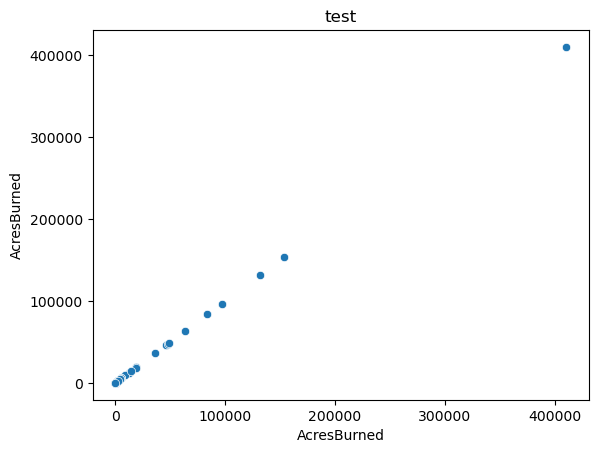

In [43]:
sns.scatterplot(x=test.AcresBurned, y=test.AcresBurned)
plt.title('test')

Text(0.5, 1.0, 'val')

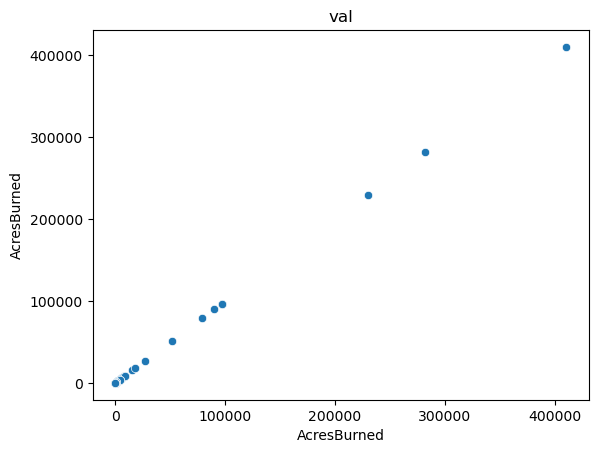

In [44]:
sns.scatterplot(x=val.AcresBurned, y=val.AcresBurned)
plt.title('val')

In [49]:
train.to_csv('../Data/train_data.csv')
test.to_csv('../Data/test_data.csv')
val.to_csv('../Data/val_data.csv')